# 🧠 Mental Health Status Classification (Baseline Models)
**Capstone Project | MSc Data Science**

## 📌 Overview
This notebook covers the **Exploratory Data Analysis (EDA)** and **Classical Machine Learning** baseline for a multi-class classification system detecting 7 mental health statuses (Anxiety, Depression, Suicidal, etc.).

## 🛠 Key Techniques
* **Preprocessing:** Custom text cleaning, lemmatization, and negation handling.
* **Feature Engineering:** TF-IDF Vectorization (up to 3-grams).
* **Models Evaluated:** Logistic Regression, LinearSVC, SGD, MultinomialNB.
* **Interpretability:** Jaccard Similarity of top words & DSM-5 Symptom mapping.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
filepath = "compressed_data.csv.gz"
df = pd.read_csv(filepath)
print(df['status'].value_counts())

# Basic cleaning
df.dropna(subset=['statement', 'status'], inplace=True)
df.drop_duplicates(subset=['statement'], inplace=True)

# Drop unwanted columns if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

print(f"Data loaded. Full size: {len(df)} rows.")
print(df.head())


status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64
Data loaded. Full size: 51073 rows.
                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety


# Visualise Original Class Distribution

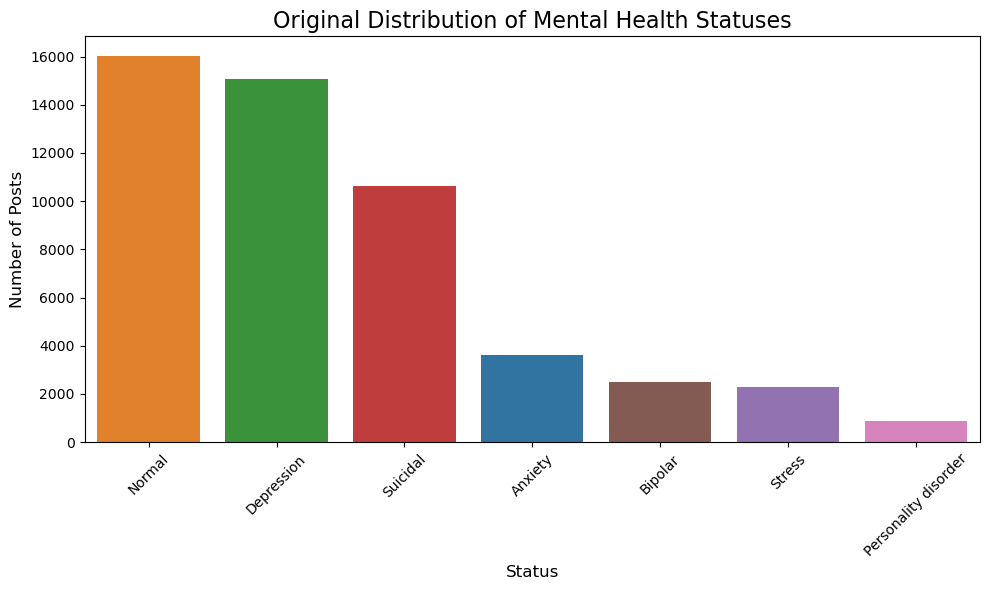


Class counts:
status
Normal                  16039
Depression              15087
Suicidal                10641
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64


In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df, 
    x='status', 
    order=df['status'].value_counts().index,
    hue='status'
)
plt.title('Original Distribution of Mental Health Statuses', fontsize=16)
plt.ylabel('Number of Posts', fontsize=12)
plt.xlabel('Status', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nClass counts:")
print(df['status'].value_counts())


# Emotion-Preserving Preprocessing

In [4]:
lemmatizer = WordNetLemmatizer()
base_stopwords = set(stopwords.words('english'))

# We REMOVE these from stopwords to keep them
pronouns_and_negations = {
    'i', 'me', 'my', 'mine', 'myself',
    'you', 'your', 'yours', 'yourself',
    'he', 'him', 'his', 'himself',
    'she', 'her', 'hers', 'herself',
    'we', 'us', 'our', 'ours', 'ourselves',
    'they', 'them', 'their', 'theirs', 'themselves',
    'not', 'no', 'nor', 'never'
}
stop_words = base_stopwords - pronouns_and_negations

contractions_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "didnt": "did not",
    "doesnt": "does not", "dont": "do not", "cant": "cannot",
    "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will", "he's": "he is",
    "i'd": "i would", "i'll": "i will", "i'm": "i am", "im": "i am", "i've": "i have",
    "isn't": "is not", "it's": "it is", "lets": "let us", "let's": "let us",
    "mustn't": "must not", "shan't": "shall not",
    "she'd": "she would", "she'll": "she will", "she's": "she is",
    "shouldn't": "should not", "that's": "that is", "there's": "there is",
    "they'd": "they would", "they'll": "they will", "they're": "they are", "they've": "they have",
    "we'd": "we would", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will",
    "what're": "what are", "what's": "what is", "what've": "what have",
    "where's": "where is", "who'd": "who would", "who'll": "who will",
    "who're": "who are", "who's": "who is", "who've": "who have",
    "won't": "will not", "wouldn't": "would not",
    "you'd": "you would", "you'll": "you will", "you're": "you are", "youve": "you have", "you've": "you have"
}


def expand_contractions(text):
    for contraction, expansion in contractions_dict.items():
        text = re.sub(r"\b" + re.escape(contraction) + r"\b", expansion, text, flags=re.IGNORECASE)
    return text

def preprocess_text(text):
    text = str(text)

    # 1. Expand contractions
    text = expand_contractions(text)

    # 2. Lowercase
    text = text.lower()


    # 3. Remove URLs, mentions, hashtags (but keep their emotional content lost anyway)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # 4. Keep letters, spaces, and basic emotional punctuation ! ?
    #    We'll keep ! and ? by temporarily marking them
    text = text.replace('!', ' exclammark ')
    text = text.replace('?', ' questionmark ')

    # Remove anything that's not a-z or space
    text = re.sub(r'[^a-z\s]', ' ', text)

    # 5. Tokenize
    tokens = word_tokenize(text)

    cleaned_tokens = []
    for tok in tokens:
        if tok in {'exclammark', 'questionmark'}:
            cleaned_tokens.append(tok)
            continue

        if tok in stop_words:
            continue

        if len(tok) < 2:   # remove single-letter tokens only
            continue

        lemma = lemmatizer.lemmatize(tok)
        cleaned_tokens.append(lemma)

    return " ".join(cleaned_tokens)


sample_text = df['statement'].iloc[5]
print("ORIGINAL:\n", sample_text)
print("\nCLEANED:\n", preprocess_text(sample_text))

#Apply to full dataset:
df['cleaned_statement'] = df['statement'].astype(str).apply(preprocess_text)
print("Text preprocessing complete.")
df[['status', 'statement', 'cleaned_statement']].sample(5, random_state=42)

ORIGINAL:
 every break, you must be nervous, like something is wrong, but what the heck

CLEANED:
 every break you must nervous like something wrong heck
Text preprocessing complete.


,status,statement,cleaned_statement
33805,Normal,he's been a chain smoker for 30 years.,he chain smoker year
49563,Bipolar,Dependence on therapist I attend IOP groups an...,dependence therapist attend iop group individu...
24072,Depression,These feelings constantly come back. Someone f...,feeling constantly come back someone my past h...
18652,Depression,Not only do I not fully believe in myself but ...,not not fully believe myself also verge not ca...
42999,Normal,blahhh my throat is sore amp i keep coughing i...,blahhh my throat sore amp keep coughing hate sick


# Visualise Text Lengths

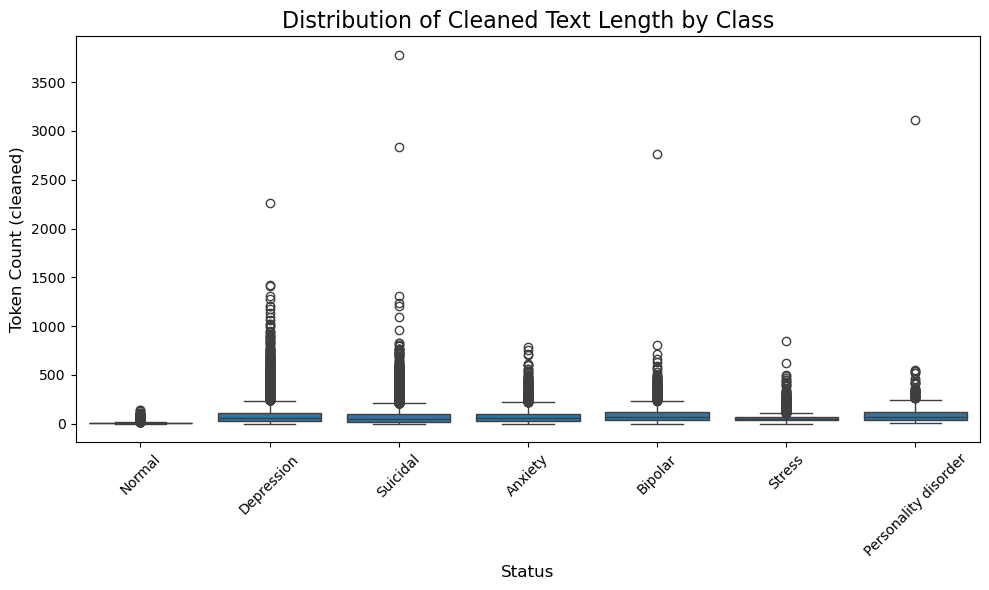

In [5]:
df['text_len'] = df['cleaned_statement'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='status', y='text_len', order=df['status'].value_counts().index)
plt.title('Distribution of Cleaned Text Length by Class', fontsize=16)
plt.ylabel('Token Count (cleaned)', fontsize=12)
plt.xlabel('Status', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Train/Test Split + TF-IDF

In [6]:
X = df['cleaned_statement']
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")


vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),       # unigrams + bigrams
    max_features=15000,
    min_df=5,                  # ignore very rare tokens
    sublinear_tf=True
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


Training set size: 35751, Test set size: 15322
TF-IDF shapes: (35751, 15000) (15322, 15000)


# Baseline Models 

In [7]:
labels = sorted(df['status'].unique())

def plot_confusion(cm, labels, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='viridis',
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'label': 'Sample Count'},
        linewidths=0.3
    )
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


## Logistic Regression

In [8]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

log_reg.fit(X_train_tfidf, y_train)
y_pred_lr = log_reg.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nLogistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.7403733194099987

Logistic Regression Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.74      0.81      0.78      1085
             Bipolar       0.70      0.75      0.72       750
          Depression       0.76      0.58      0.66      4526
              Normal       0.89      0.92      0.90      4812
Personality disorder       0.43      0.59      0.50       269
              Stress       0.42      0.65      0.51       688
            Suicidal       0.65      0.70      0.68      3192

            accuracy                           0.74     15322
           macro avg       0.65      0.72      0.68     15322
        weighted avg       0.75      0.74      0.74     15322



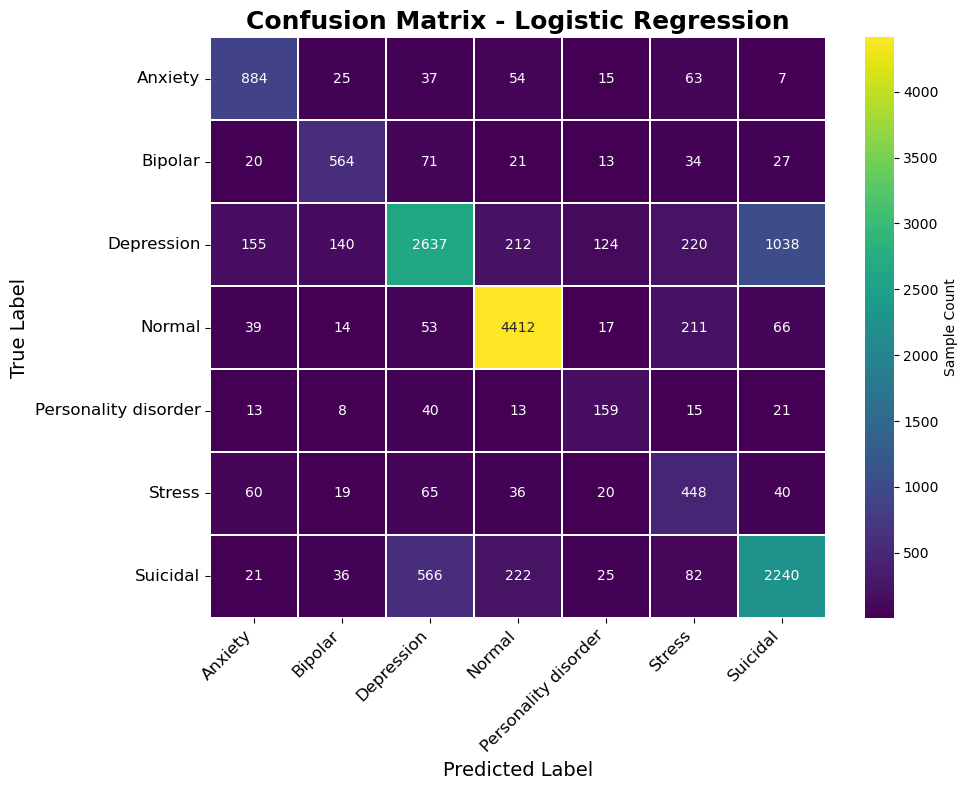

In [9]:
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=labels)
plot_confusion(cm_lr, labels, "Confusion Matrix - Logistic Regression")

## Linear SVC

LinearSVC Accuracy: 0.732606709306879

LinearSVC Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.73      0.78      0.75      1085
             Bipolar       0.73      0.71      0.72       750
          Depression       0.70      0.63      0.66      4526
              Normal       0.88      0.94      0.90      4812
Personality disorder       0.56      0.45      0.50       269
              Stress       0.45      0.47      0.46       688
            Suicidal       0.63      0.64      0.63      3192

            accuracy                           0.73     15322
           macro avg       0.67      0.66      0.66     15322
        weighted avg       0.73      0.73      0.73     15322



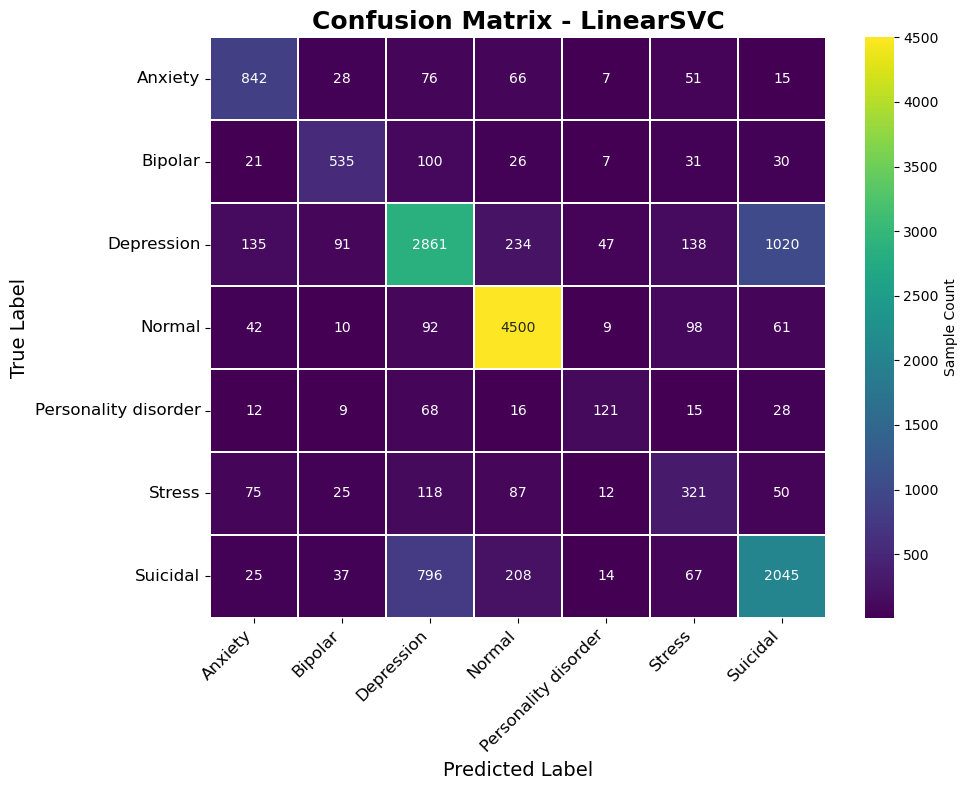

In [10]:
svm_clf = LinearSVC(class_weight='balanced')
svm_clf.fit(X_train_tfidf, y_train)
y_pred_svm = svm_clf.predict(X_test_tfidf)

print("LinearSVC Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nLinearSVC Classification Report:\n")
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)
plot_confusion(cm_svm, labels, "Confusion Matrix - LinearSVC")

## SGDClassifier

SGD Classifier Accuracy: 0.7299960840621329

SGD Classifier Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.74      0.78      0.76      1085
             Bipolar       0.73      0.70      0.71       750
          Depression       0.74      0.60      0.66      4526
              Normal       0.82      0.94      0.88      4812
Personality disorder       0.44      0.57      0.50       269
              Stress       0.46      0.57      0.51       688
            Suicidal       0.66      0.64      0.65      3192

            accuracy                           0.73     15322
           macro avg       0.66      0.68      0.67     15322
        weighted avg       0.73      0.73      0.73     15322



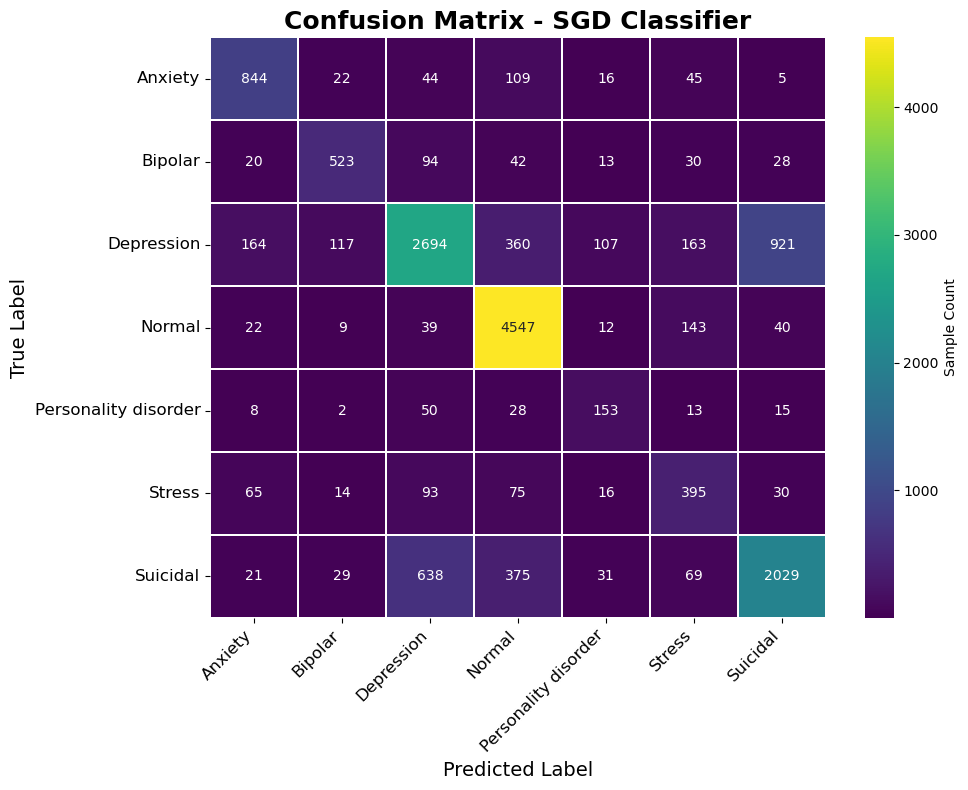

In [11]:
sgd_clf = SGDClassifier(
    loss='log_loss',
    class_weight='balanced',
    max_iter=1000,
    tol=1e-3
)
sgd_clf.fit(X_train_tfidf, y_train)
y_pred_sgd = sgd_clf.predict(X_test_tfidf)

print("SGD Classifier Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("\nSGD Classifier Classification Report:\n")
print(classification_report(y_test, y_pred_sgd))

cm_sgd = confusion_matrix(y_test, y_pred_sgd, labels=labels)
plot_confusion(cm_sgd, labels, "Confusion Matrix - SGD Classifier")


## MultinomialNB

MultinomialNB Accuracy: 0.6659052343036157

Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.81      0.55      0.66      1085
             Bipolar       0.89      0.28      0.43       750
          Depression       0.52      0.79      0.62      4526
              Normal       0.84      0.84      0.84      4812
Personality disorder       1.00      0.01      0.01       269
              Stress       1.00      0.01      0.02       688
            Suicidal       0.68      0.55      0.61      3192

            accuracy                           0.67     15322
           macro avg       0.82      0.43      0.46     15322
        weighted avg       0.72      0.67      0.64     15322



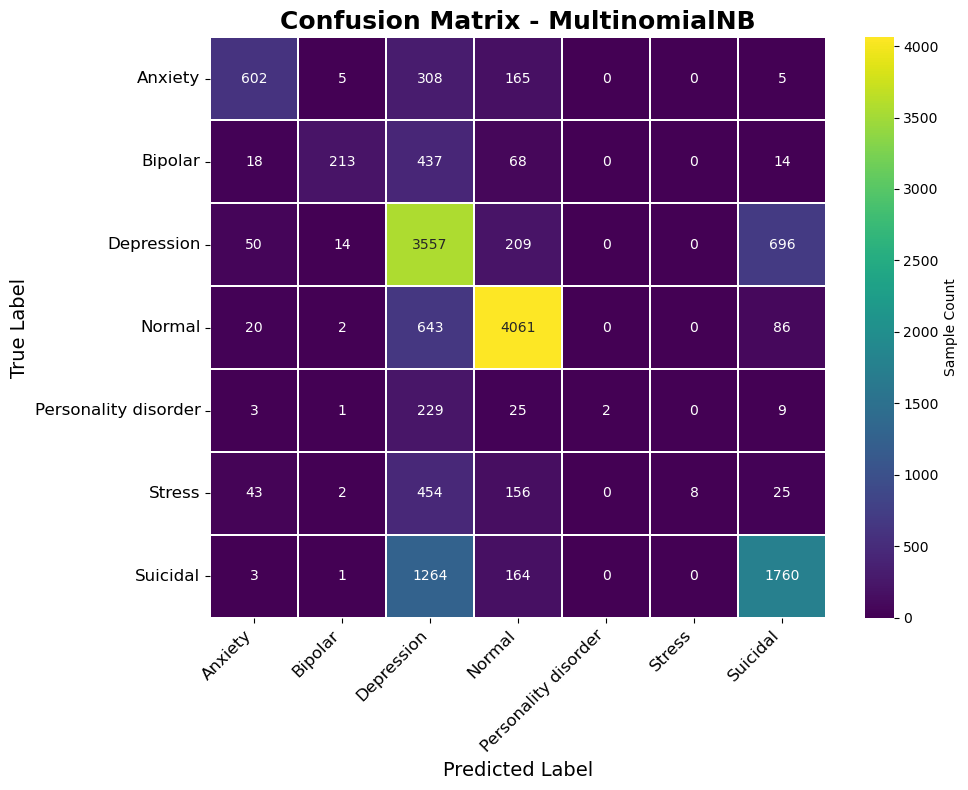

In [12]:
# MULTINOMIAL NAIVE BAYES
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)
y_pred_nb = nb_clf.predict(X_test_tfidf)

print("MultinomialNB Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb, labels=labels)
plot_confusion(cm_nb, labels, "Confusion Matrix - MultinomialNB")

## Ridge Classifier

RidgeClassifier Accuracy: 0.6972980028716877

Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.68      0.77      0.72      1085
             Bipolar       0.66      0.71      0.68       750
          Depression       0.72      0.54      0.61      4526
              Normal       0.83      0.89      0.86      4812
Personality disorder       0.40      0.48      0.44       269
              Stress       0.35      0.52      0.42       688
            Suicidal       0.62      0.66      0.64      3192

            accuracy                           0.70     15322
           macro avg       0.61      0.65      0.63     15322
        weighted avg       0.71      0.70      0.70     15322



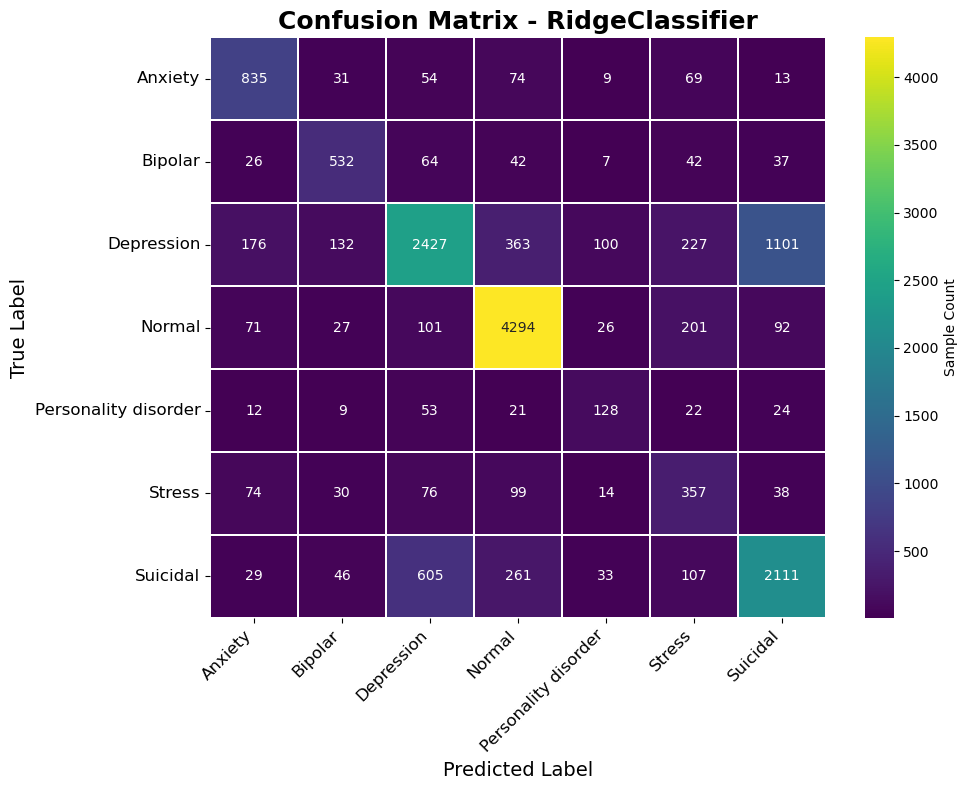

In [13]:
ridge_clf = RidgeClassifier(class_weight='balanced',solver='lsqr',alpha=0.5)
ridge_clf.fit(X_train_tfidf, y_train)
y_pred_ridge = ridge_clf.predict(X_test_tfidf)

print("RidgeClassifier Accuracy:", accuracy_score(y_test, y_pred_ridge))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_ridge))

cm_ridge = confusion_matrix(y_test, y_pred_ridge, labels=labels)
plot_confusion(cm_ridge, labels, "Confusion Matrix - RidgeClassifier")

# Enhanced TF-IDF Features

In [14]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),        # unigrams + bigrams + trigrams
    max_features=30000,        # more vocabulary
    min_df=3,                  # remove too rare terms
    sublinear_tf=True          # better weighting for longer texts
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("New TF-IDF:", X_train_tfidf.shape, X_test_tfidf.shape)

New TF-IDF: (35751, 30000) (15322, 30000)


## Logistic Regression (TF-IDF 30k 1-3gram)

In [15]:
log_reg_30k = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

log_reg_30k.fit(X_train_tfidf, y_train)
y_pred_lr_30k = log_reg_30k.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr_30k))
print("\nLogistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_lr_30k))


Logistic Regression Accuracy: 0.7414828351390158

Logistic Regression Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.75      0.82      0.78      1085
             Bipolar       0.70      0.74      0.72       750
          Depression       0.75      0.59      0.66      4526
              Normal       0.89      0.92      0.90      4812
Personality disorder       0.45      0.58      0.50       269
              Stress       0.43      0.64      0.52       688
            Suicidal       0.65      0.70      0.67      3192

            accuracy                           0.74     15322
           macro avg       0.66      0.71      0.68     15322
        weighted avg       0.75      0.74      0.74     15322



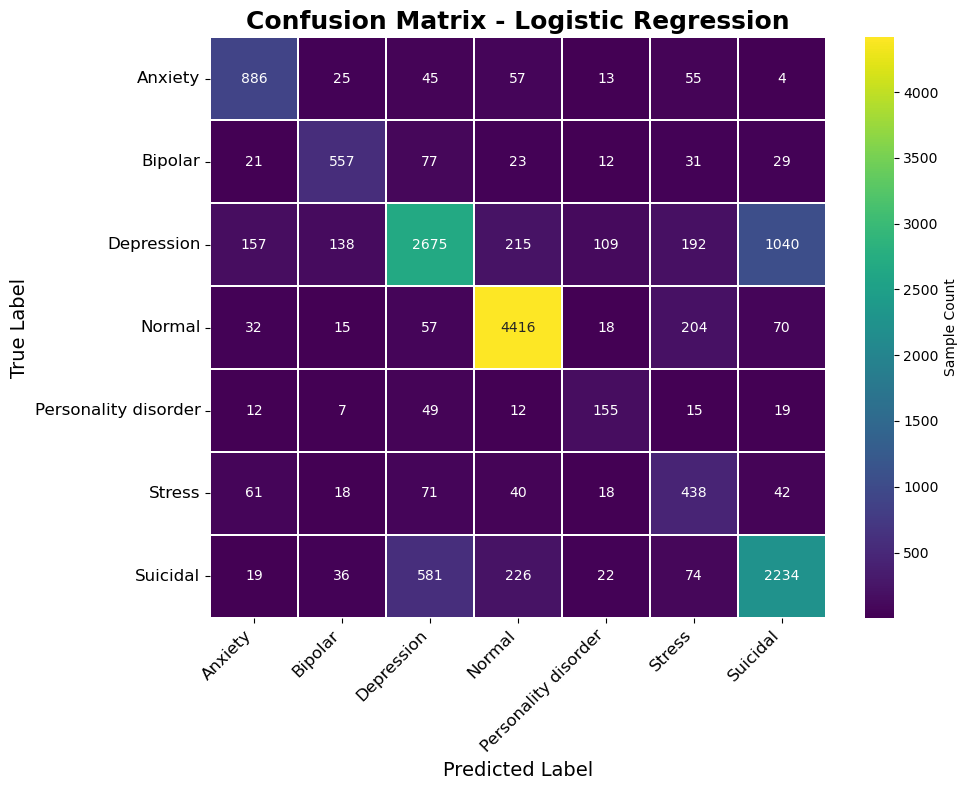

In [16]:
cm_lr = confusion_matrix(y_test, y_pred_lr_30k, labels=labels)
plot_confusion(cm_lr, labels, "Confusion Matrix - Logistic Regression")

## LinearSVC (TF-IDF 30k 1-3gram)

Improved LinearSVC Accuracy: 0.740503850672236
                      precision    recall  f1-score   support

             Anxiety       0.74      0.78      0.76      1085
             Bipolar       0.76      0.72      0.74       750
          Depression       0.70      0.64      0.67      4526
              Normal       0.87      0.94      0.90      4812
Personality disorder       0.66      0.43      0.52       269
              Stress       0.50      0.47      0.48       688
            Suicidal       0.63      0.65      0.64      3192

            accuracy                           0.74     15322
           macro avg       0.69      0.66      0.67     15322
        weighted avg       0.74      0.74      0.74     15322



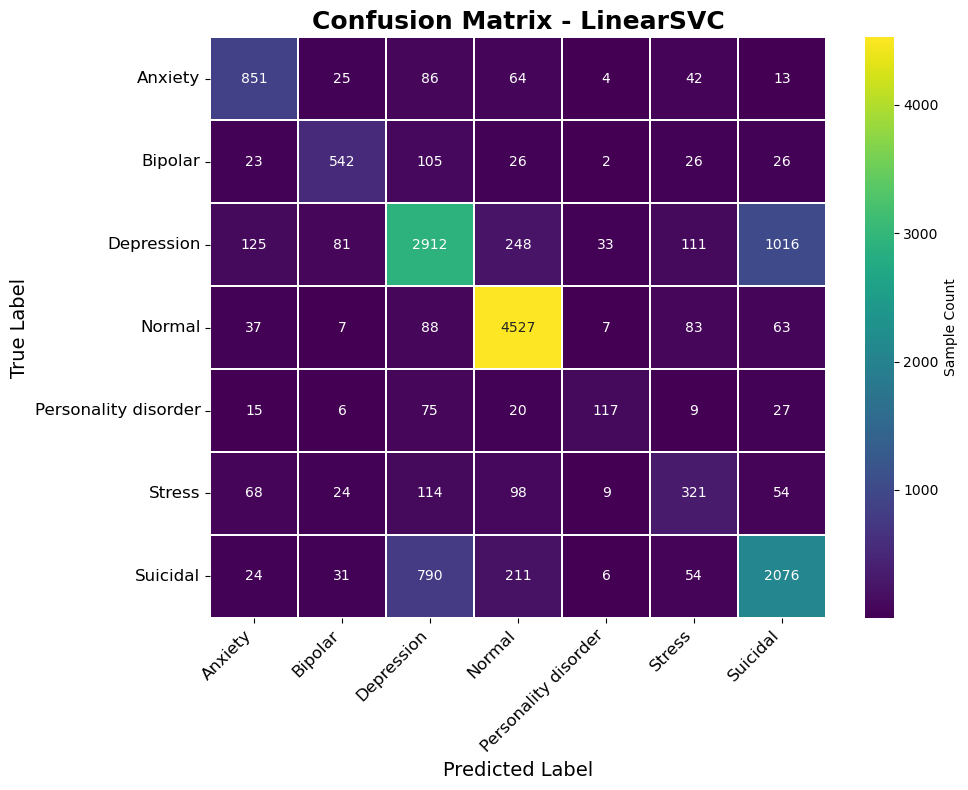

In [17]:
svm_clf = LinearSVC(class_weight='balanced')
svm_clf.fit(X_train_tfidf, y_train)

y_pred_svm_30k = svm_clf.predict(X_test_tfidf)

print("Improved LinearSVC Accuracy:", accuracy_score(y_test, y_pred_svm_30k))
print(classification_report(y_test,y_pred_svm_30k))


cm_svm = confusion_matrix(y_test, y_pred_svm_30k, labels=labels)
plot_confusion(cm_svm, labels, "Confusion Matrix - LinearSVC")

# Baseline Comparison 

In [18]:
results_list = []

def add_result(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    results_list.append({
        "Model": model_name,
        "Accuracy": acc,
        "Macro F1": f1
    })

# Add each trained model
add_result("Logistic Regression (TF-IDF 15k)", y_test, y_pred_lr)
add_result("LinearSVC (TF-IDF 15k)", y_test, y_pred_svm)
add_result("SGDClassifier (TF-IDF 15k)", y_test, y_pred_sgd)
add_result("MultinomialNB (TF-IDF 15k)", y_test, y_pred_nb)
add_result("RidgeClassifier (TF-IDF 15k)", y_test, y_pred_ridge)

# If trained with TF-IDF 30k
add_result("Logistic Regression (TF-IDF 30k 1-3gram)", y_test, y_pred_lr_30k)
add_result("LinearSVC (TF-IDF 30k 1-3gram)", y_test, y_pred_svm_30k)

# Create dataframe
results_df = pd.DataFrame(results_list)
display(results_df.sort_values("Accuracy", ascending=False))

,Model,Accuracy,Macro F1
5,Logistic Regression (TF-IDF 30k 1-3gram),0.741483,0.679528
6,LinearSVC (TF-IDF 30k 1-3gram),0.740504,0.674958
0,Logistic Regression (TF-IDF 15k),0.740373,0.677552
1,LinearSVC (TF-IDF 15k),0.732607,0.661289
2,SGDClassifier (TF-IDF 15k),0.729996,0.666234
4,RidgeClassifier (TF-IDF 15k),0.697298,0.625032
3,MultinomialNB (TF-IDF 15k),0.665905,0.457301


<!-- # TF-IDF + Word2Vec hybrid


# # 1) TF-IDF on train/test
# vectorizer = TfidfVectorizer(
#     ngram_range=(1, 3),
#     max_features=30000,
#     min_df=3,
#     sublinear_tf=True
# )
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf  = vectorizer.transform(X_test)

# # Using the sentence_vector() function you already defined

# X_train_w2v = np.array([sentence_vector(text.split()) for text in X_train])
# X_test_w2v  = np.array([sentence_vector(text.split()) for text in X_test])

# print(X_train_w2v.shape, X_test_w2v.shape)   # should be (n_train, 300), (n_test, 300)

# from sklearn.decomposition import TruncatedSVD

# svd = TruncatedSVD(n_components=300, random_state=42)
# X_train_tfidf_red = svd.fit_transform(X_train_tfidf)
# X_test_tfidf_red  = svd.transform(X_test_tfidf)

# # Hybrid = [TF-IDF-reduced || Word2Vec]
# X_train_hybrid = np.hstack([X_train_tfidf_red, X_train_w2v])
# X_test_hybrid  = np.hstack([X_test_tfidf_red, X_test_w2v])

# print(X_train_hybrid.shape, X_test_hybrid.shape)  # ~ (n_train, 600)

# hybrid_svm = LinearSVC(class_weight='balanced')
<!-- # hybrid_svm.fit(X_train_hybrid, y_train)
# hybrid_pred = hybrid_svm.predict(X_test_hybrid)

# print("Hybrid TF-IDF + Word2Vec Accuracy:", accuracy_score(y_test, hybrid_pred))
# print(classification_report(y_test, hybrid_pred))

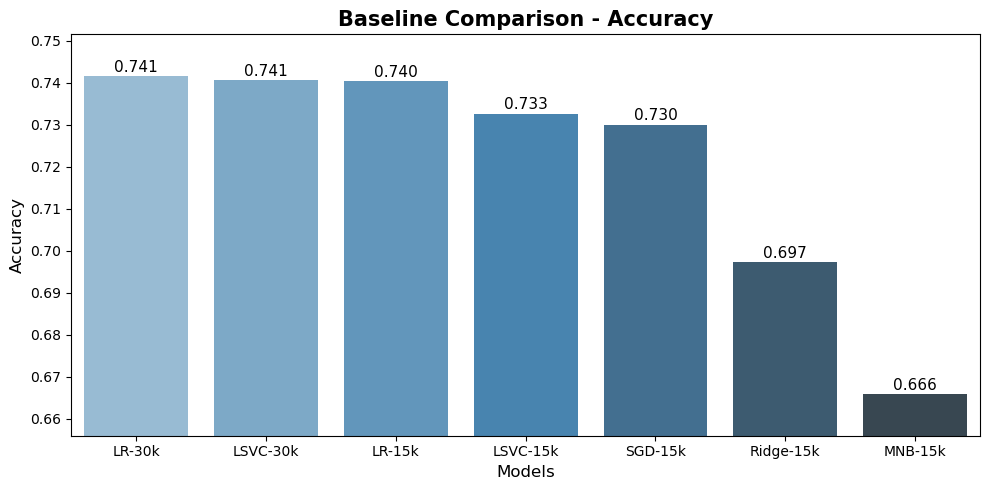

In [19]:
# Create short labels for cleaner visualization
short_labels = {
    "Logistic Regression (TF-IDF 15k)": "LR-15k",
    "LinearSVC (TF-IDF 15k)": "LSVC-15k",
    "SVC Linear (TF-IDF 15k)": "SVC-15k",
    "SGDClassifier (TF-IDF 15k)": "SGD-15k",
    "MultinomialNB (TF-IDF 15k)": "MNB-15k",
    "RidgeClassifier (TF-IDF 15k)": "Ridge-15k",
    "Logistic Regression (TF-IDF 30k 1-3gram)": "LR-30k",
    "LinearSVC (TF-IDF 30k 1-3gram)": "LSVC-30k"
}

# Apply mapping to DataFrame copy
plot_df_acc = results_df.copy()
plot_df_acc["Short Label"] = plot_df_acc["Model"].map(short_labels)

# Sort and plot
plot_df_acc = plot_df_acc.sort_values("Accuracy", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x="Short Label", 
    y="Accuracy", 
    data=plot_df_acc, 
    palette="Blues_d",
    hue = 'Short Label'
)

plt.title("Baseline Comparison - Accuracy", fontsize=15, weight="bold")
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Precise scale
plt.ylim(plot_df_acc["Accuracy"].min() - 0.01, plot_df_acc["Accuracy"].max() + 0.01)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.01))

# Add values above bars
for i, v in enumerate(plot_df_acc["Accuracy"]):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()


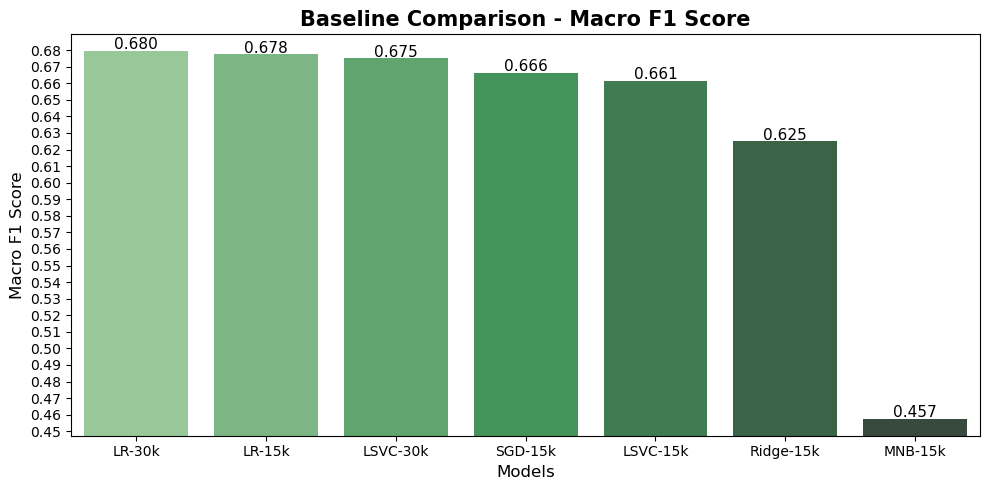

In [20]:
# Apply mapping to DataFrame copy
plot_df_f1 = results_df.copy()
plot_df_f1["Short Label"] = plot_df_f1["Model"].map(short_labels)

# Sort and plot
plot_df_f1 = plot_df_f1.sort_values("Macro F1", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x="Short Label", 
    y="Macro F1", 
    data=plot_df_f1, 
    palette="Greens_d",
    hue="Short Label"
)

plt.title("Baseline Comparison - Macro F1 Score", fontsize=15, weight="bold")
plt.xlabel("Models", fontsize=12)
plt.ylabel("Macro F1 Score", fontsize=12)

# Precise scale
plt.ylim(plot_df_f1["Macro F1"].min() - 0.01, plot_df_f1["Macro F1"].max() + 0.01)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.01))

# Add labels above bars
for i, v in enumerate(plot_df_f1["Macro F1"]):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()


# Top words per class

In [21]:
import numpy as np
import pandas as pd

# Make sure these exist:
# vectorizer, X_train_tfidf, y_train

feature_names = np.array(vectorizer.get_feature_names_out())
classes = sorted(pd.Series(y_train).unique())
top_n = 15  # number of words to show per class

top_words_per_class = {}

for cls in classes:
    # indices of rows belonging to this class
    cls_idx = np.where(np.array(y_train) == cls)[0]
    cls_tfidf = X_train_tfidf[cls_idx]

    # mean tf-idf score per feature for this class
    mean_scores = cls_tfidf.mean(axis=0).A1   # convert sparse -> 1D array

    # top N features
    top_idx = np.argsort(mean_scores)[::-1][:top_n]
    top_features = feature_names[top_idx]
    top_values = mean_scores[top_idx]

    top_words_per_class[cls] = list(zip(top_features, top_values))

# Nicely print results
for cls in classes:
    print("\n" + "="*70)
    print(f"Top {top_n} words for class: {cls}")
    print("="*70)
    for word, score in top_words_per_class[cls]:
        print(f"{word:20s}  {score:.4f}")



Top 15 words for class: Anxiety
my                    0.0404
anxiety               0.0391
questionmark          0.0351
restless              0.0326
not                   0.0286
me                    0.0224
like                  0.0218
you                   0.0205
feel                  0.0198
nervous               0.0196
worried               0.0193
anxious               0.0188
symptom               0.0179
get                   0.0171
heart                 0.0167

Top 15 words for class: Bipolar
questionmark          0.0459
my                    0.0435
bipolar               0.0412
not                   0.0294
me                    0.0292
you                   0.0251
like                  0.0250
episode               0.0243
med                   0.0234
feel                  0.0233
manic                 0.0233
anyone                0.0195
know                  0.0192
get                   0.0187
time                  0.0184

Top 15 words for class: Depression
my                    0.0397

# Jaccard Overlap of Top Words Between Classes

Classes: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']


,Anxiety,Bipolar,Depression,Normal,Personality disorder,Stress,Suicidal
Anxiety,1.000000,0.010101,0.000000,0.000000,0.010101,0.010101,0.010101
Bipolar,0.010101,1.000000,0.030928,0.000000,0.020408,0.010101,0.010101
Depression,0.000000,0.030928,1.000000,0.020408,0.020408,0.010101,0.136364
Normal,0.000000,0.000000,0.020408,1.000000,0.000000,0.020408,0.000000
Personality disorder,0.010101,0.020408,0.020408,0.000000,1.000000,0.010101,0.010101
Stress,0.010101,0.010101,0.010101,0.020408,0.010101,1.000000,0.000000
Suicidal,0.010101,0.010101,0.136364,0.000000,0.010101,0.000000,1.000000


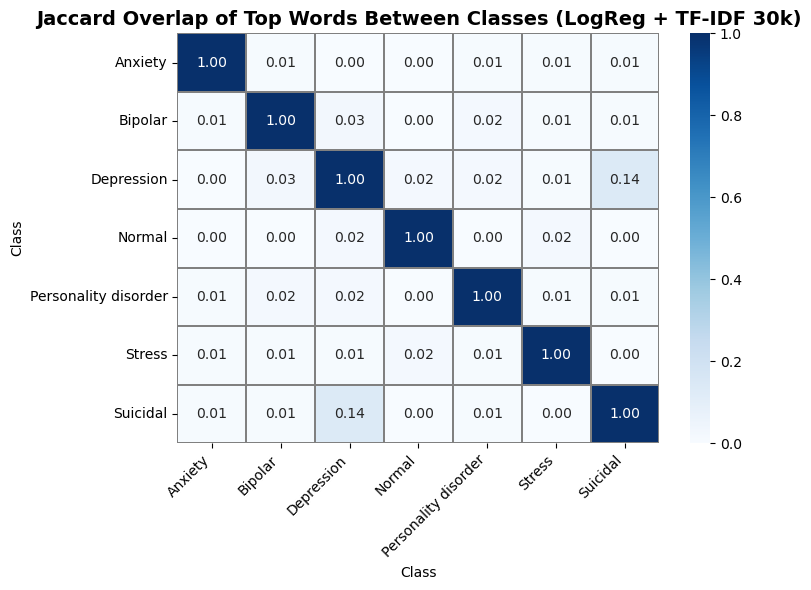

In [22]:
feature_names = np.array(vectorizer.get_feature_names_out())
classes = log_reg_30k.classes_   # e.g. ['Anxiety', 'Bipolar', ..., 'Suicidal']
print("Classes:", classes)

top_k = 50  # number of top words per class to consider
top_words_per_class = {}

# Collect top-K words for each class based on model coefficients 
for i, cls in enumerate(classes):
    coefs = log_reg_30k.coef_[i]     # shape: (n_features,)
    top_idx = np.argsort(coefs)[::-1][:top_k]
    top_tokens = feature_names[top_idx]
    top_words_per_class[cls] = set(top_tokens)

#  Build Jaccard overlap matrix between classes 
n_classes = len(classes)
overlap_matrix = np.zeros((n_classes, n_classes))

for i, ci in enumerate(classes):
    for j, cj in enumerate(classes):
        set_i = top_words_per_class[ci]
        set_j = top_words_per_class[cj]
        inter = len(set_i & set_j)
        union = len(set_i | set_j)
        overlap_matrix[i, j] = inter / union if union > 0 else 0.0

overlap_df = pd.DataFrame(overlap_matrix, index=classes, columns=classes)
display(overlap_df)

plt.figure(figsize=(8, 6))
sns.heatmap(
    overlap_df,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    vmin=0.0,
    vmax=1.0,
    linewidths=0.3,
    linecolor="grey"
)
plt.title("Jaccard Overlap of Top Words Between Classes (LogReg + TF-IDF 30k)", fontsize=14, weight="bold")
plt.xlabel("Class")
plt.ylabel("Class")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# DSM-5 style symptom categories

In [23]:
# Collect union of top-N words per class from the same LogReg model
top_n = 30  
feature_names = np.array(vectorizer.get_feature_names_out())
classes = log_reg_30k.classes_

token_sets = {}
all_tokens = set()

for i, cls in enumerate(classes):
    coefs = log_reg_30k.coef_[i]
    idx = np.argsort(coefs)[::-1][:top_n]
    tokens = feature_names[idx]
    token_sets[cls] = set(tokens)
    all_tokens.update(tokens)

print("Total unique tokens across all classes:", len(all_tokens))

# Define DSM-5 style symptom categories & keywords 

dsm_categories = {
    "Depressive symptoms": {
        "sad", "empty", "worthless", "guilty", "hopeless",
        "tired", "numb", "anhedonia", "cry", "tears",
        "alone", "isolated", "fatigue", "sleep", "insomnia",
        "appetite", "weight", "low", "motivation"
    },
    "Suicidal ideation / self-harm": {
        "die", "suicide", "suicidal", "kill", "end",
        "cut", "cutting", "selfharm", "overdose", "jump",
        "myself"
    },
    "Anxiety / worry / panic": {
        "anxiety", "anxious", "panic", "worried", "worry",
        "nervous", "restless", "symptom", "heart", "racing",
        "attack", "fear"
    },
    "Manic / bipolar features": {
        "bipolar", "manic", "mania", "hypomanic", "episode",
        "med", "meds", "rapid", "cycle"
    },
    "Stress / overload": {
        "stress", "stressed", "overwhelmed", "pressure",
        "burnout", "deadline"
    },
    "Personality / social avoidance": {
        "avpd", "avoidant", "avoid", "social", "people",
        "them", "crowd"
    }
}

# Build mapping table: Word -> DSM Category -> Classes where present 

rows = []

for token in sorted(all_tokens):
    assigned_cats = []
    for cat, vocab in dsm_categories.items():
        if token in vocab:
            assigned_cats.append(cat)
    if not assigned_cats:
        # skip neutral/high-frequency tokens like "my", "not", "like", etc.
        continue

    present_in_classes = [cls for cls in classes if token in token_sets[cls]]

    rows.append({
        "Word": token,
        "DSM-5 Symptom Category": "; ".join(assigned_cats),
        "Appears in Classes": ", ".join(present_in_classes)
    })

dsm_df = pd.DataFrame(rows).sort_values(
    ["DSM-5 Symptom Category", "Word"]
).reset_index(drop=True)

display(dsm_df)


Total unique tokens across all classes: 192


,Word,DSM-5 Symptom Category,Appears in Classes
0,anxiety,Anxiety / worry / panic,"Anxiety, Stress"
1,anxious,Anxiety / worry / panic,Anxiety
2,attack,Anxiety / worry / panic,Stress
3,fear,Anxiety / worry / panic,"Anxiety, Personality disorder"
4,heart,Anxiety / worry / panic,Anxiety
5,nervous,Anxiety / worry / panic,Anxiety
6,panic,Anxiety / worry / panic,Anxiety
7,restless,Anxiety / worry / panic,Anxiety
8,symptom,Anxiety / worry / panic,Anxiety
9,worried,Anxiety / worry / panic,Anxiety
